# Untersuchung von XAI Methoden

Hier wird untersucht was Ergebnisse der XAI Methoden mit dem Alexnet sind. Für XAI gibt es eine gute Library namens Captum. Captum bietet eine vielzahl von Methoden an.

## 0. Model und Libraries laden


In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from torchvision import transforms
import pandas as pd
from random import randint
from PIL import Image, ImageOps
import os
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients,\
    GradientShap,Occlusion,NoiseTunnel,visualization as viz

from cnn import AlexNet


torch.manual_seed(0)
np.random.seed(0)


5 verschiedene Modelle laden, mit verschiedenen Initialisierungsseeds

In [2]:
data_path = "../../../data/"
models_path = data_path + "xai/nih/models/"

In [10]:
models_folder = os.listdir(models_path)

In [11]:
model_list = []
for mo in models_folder:
    print(mo)
    model = AlexNet().to("cpu")
    model.load_state_dict(torch.load(models_path+f"{mo}",map_location=torch.device('cpu')))
    model = model.eval()
    model_list.append(model)
    del model

testAcc0_90106545.pth
vL0_00016008.pth
vL0_00768024.pth
vL0_00505538.pth
zvL0_67123288.pth


## 1.0 Datensatz lesen

In [53]:
# load the image from filtered Dataset
df = pd.read_csv(data_path+"/Chest/BBox_List_2017_pneumo_cardio_lean.csv")
sample_0 = df[df['Finding Label']==0].sample(1)["path"].tolist()[0]
sample_1 = df[df['Finding Label']==1].sample(1)["path"].tolist()[0]

### 1.1 transform images

In [13]:
transform = transforms.Compose(
        [
         transforms.Grayscale(num_output_channels=3),
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         ]
    )

transform_normalize = transforms.Normalize(
     mean=0.5,
     std=0.5
 )

In [14]:
def load_image(path,model):
    print(data_path + "Chest/" + path)
    img = Image.open(data_path + "Chest/" + path)
    transformed_img = transform(img)

    input = transform_normalize(transformed_img)
    input = input.unsqueeze(0)

    output = model(input)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

    pred_label_idx.squeeze_()
    print("path      = ",path)
    truth_label_idx =  df[df['path']==path]['Finding Label'].tolist()[0]
    print("Truth     =",truth_label_idx)
    print('Predicted =', pred_label_idx.item(), '(with score of', prediction_score.squeeze().item(), ')')
    return {"input" :input,
     "output":output,
     "pred_label_idx":pred_label_idx.item(),
     "truth_label_idx":truth_label_idx,
     "transformed_img":transformed_img
     }

Testen von load_image

In [16]:
sample_0_results = load_image(sample_0,model_list[0])

../../../data/Chest/images_001/images/00000756_001.png
path      =  images_001/images/00000756_001.png
Truth     = 0
Predicted = 0 (with score of 0.9999529123306274 )


In [17]:
sample_1_results = load_image(sample_1,model_list[0])

../../../data/Chest/images_005/images/00010071_008.png
path      =  images_005/images/00010071_008.png
Truth     = 1
Predicted = 1 (with score of 1.0 )


## 2.0 Vergleichsmetik

### 2.1 Entropie

Man sieht dass sich die Bilder stark ähnenel. In diesem Beispeil scheint sich das Modell Nr 4 leicht zu unterscheiden. Es fällt auch auf, dass Modell Nr4 die Informationen aus dem Hintergrund mit einbezieht, was nicht gut ist. Die Frage ist nun wie wertet man den Unterschiede dieser Heatmaps mit einer Evaluationsmetrik aus. Es gibt verschiedene Ansätz dazu:
- Entropie

Ein Problem dieser Methoden ist, dass der Algorithmus nur die einzelnen Reihen miteinander vergleicht. Darum werde ich eine andere Methode versuchen:
1. Bestimmung des "Center of Mass"
2. Abstand jedes Pixels zum COM
3. Multipliziert mit dem Wert des Pixels (weighted Distance)


In [24]:
def entropy(df,path):
    entropies = []
    for s in df["path"].tolist():
        img = path + s[18:]
        img = Image.open(img)
        img = ImageOps.grayscale(img)
        img = ImageOps.invert(img)
        arr = np.asarray(img)
        arr = arr[1:-1,1:-1]
        # Compute normalized histogram -> p(g)
        p = np.array([(arr == v).sum() for v in range(256)])
        p = p / p.sum()
        # Compute e = -sum(p(g)*log2(p(g)))
        e = -(p[p > 0] * np.log2(p[p > 0])).sum()
        entropies.append(e)
    return entropies

In [25]:
def load_entropy(df,method):
    results = {}
    for i in range(1,len(model_list)+1):
        results[f"model{i}"] = entropy(df,data_path +f"xai/nih/{method}/heat_map/model{i}/")
    return results

### 2.2 Distance from Center of Mass

In [26]:
def weighted_dist_from_COM(df,path):
    distances_mean = []
    for s in df["path"].tolist():
        img = path + s[18:]
        img = Image.open(img)
        img = img.resize((244,244))
        img = ImageOps.grayscale(img)
        img = ImageOps.invert(img)
        arr = np.asarray(img)/255
        arr = arr[1:-1,1:-1]
        center = scipy.ndimage.center_of_mass(arr)
        distances = []
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                if arr[i,j]==0.0:
                    continue
                else:
                    a = np.abs(center[0]-i)
                    b = np.abs(center[1]-j)
                    distance = (a+b)**(1/2)
                    weighted_distance = distance * arr[i,j]
                    distances.append(weighted_distance)
        distances_mean.append(sum(distances)/len(distances))
    return distances_mean

In [163]:
def load_wdCOM(df,method):
    results = {}
    for i in range(1,len(model_list)+1):
        results[f"model{i}"] = weighted_dist_from_COM(df,data_path +f"xai/nih/{method}/heat_map/model{i}/")
    return results

## 3.0 Integrated Gradienten
Integrierte Gradienten stellen das Integral der Gradienten in Bezug auf die Eingaben entlang des Pfades von einer gegebenen Basislinie zur Eingabe dar. Das Integral kann mit Hilfe der Riemannschen Summe oder der Gauß-Legendre-Quadraturregel angenähert werden. Formal kann es wie folgt beschrieben werden:

IG_eq1 Integrierted Gradienten entlang der i-ten Dimension der Eingabe X. Alpha ist der Skalierungskoeffizient. Die Gleichungen sind aus dem Originalbeitrag übernommen.

Die Eckpfeiler dieses Ansatzes sind zwei grundlegende Axiome, nämlich Empfindlichkeit und Implementierungsinvarianz. Weitere Informationen zu diesen Axiomen finden Sie in der Originalarbeit.



Die Visualisierungen können folgende Formen haben:
1. `heat_map` - Display heat map of chosen attributions
2. `blended_heat_map` - Overlay heat map over greyscale version of original image. Parameter alpha_overlay corresponds to alpha of heat map.
3. `original_image` - Only display original image.
4. `masked_image` - Mask image (pixel-wise multiply) by normalized attribution values.
5. `alpha_scaling` - Sets alpha channel of each pixel
                       to be equal to normalized attribution value.


In [18]:
colors = ["#FF00FF", "#76BA1B"]
labels = ["Cardiomaly", "Pneomothorax", ]

### 3.1 Laden der Captum Funktion

In [19]:
def run_integrated_gradient(model,input,pred_label_idx,color,transformed_img,methode = "heat_map"):
    # Create IntegratedGradients object and get attributes
    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=5)

    # create custom colormap for visualizing the result
    default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                     [(0, '#ffffff'),
                                                      (1, color)], N=256)

    # visualize the results using the visualize_image_attr helper method
    p, f = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 methods=[methode],
                                 signs=['positive'],
                                 cmap=default_cmap,
                                 show_colorbar=False,
                                 fig_size=(5,5),
                                 alpha_overlay=0.5)
    return p

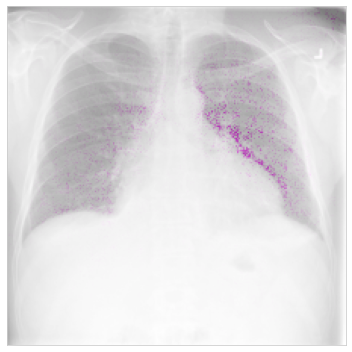

In [20]:
_ = run_integrated_gradient(model_list[0],
                        sample_0_results["input"],
                        sample_0_results["pred_label_idx"],
                        colors[0],
                        sample_0_results["transformed_img"],
                        methode="blended_heat_map"
                        )

### 3.2 Abspeichern der Heatmaps



In [21]:
# load pictures from bbox dataset
def save_all_picutures_integrated_gradient(method):
    for m in range(len(model_list)):
        direcory_xai = f"../../../data/xai/nih/integrated_gradient/"
        if not os.path.exists(direcory_xai):
            os.makedirs(direcory_xai)
        df_results_all = df.copy()
        results_entropy   = []
        results_predicted = []

        for i in df["path"].tolist():

            direcory_method = f"{direcory_xai}/{method}"
            if not os.path.exists(direcory_method):
                os.makedirs(direcory_method)

            direcory_model = f"{direcory_method}/model{m+1}"
            if not os.path.exists(direcory_model):
                os.makedirs(direcory_model)

            results = load_image(f"{i}",model_list[m])
            results_entropy.append(entropy("../../../data/Chest/" + i))
            results_predicted.append(results['pred_label_idx'])

            p = run_integrated_gradient(model=model_list[m],
                                        input=results["input"],
                                        pred_label_idx=results["pred_label_idx"],
                                        color=colors[results["truth_label_idx"]],
                                        transformed_img=results["transformed_img"],
                                        methode = method
                                        )

            p.savefig(f"{direcory_model}/{i[18:]}", bbox_inches="tight",pad_inches=0)

        df_results_all["entropy"]  = results_entropy
        df_results_all["prdicted"] = results_predicted
        df_results_all.to_csv(f"../../../data/xai/nih/integrated_gradient/heat_map/model{m+1}/results.csv")

In [17]:
%%capture
#save_all_picutures_integrated_gradient(method="heat_map")

In [18]:
%%capture
#save_all_picutures_integrated_gradient(method="blended_heat_map")

In [45]:
def plot_dist(df,c,h):
    df = pd.DataFrame(df)
    mx = df.max().max()
    mn = df.min().min()
    fig = plt.figure(figsize=(20,4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(1,6):
        ax = fig.add_subplot(1, len(model_list), i)
        sns.distplot(df[f"model{i}"],ax=ax,bins=15,color=c)
        ax.set(ylim=(0, h),xlim=(mn,mx))
    plt.show()


### 3.2 Vergleich der Modelle


Es wurden 5 Modelle mit denselben Hyperparametern und denselben Datensatz trainiert. Diese unterschieden sich in dem Initialiseirungsseed und erreichen eine sehr ähnliche Accuracy.
Man würde davon ausgehen, dass Integrate Gradient ähnliche Pixelmuster, in den verschiedenen Modellen, findet.

In [164]:
def imshow_samples(sample,method):
    plt_in = 151
    for i in range(1,len(model_list)+1):
        igi  = Image.open(data_path + f"xai/nih/{method}/heat_map/model{i}/" + sample[18:])
        plt.subplot(plt_in)
        plt.imshow(igi)
        plt.axis('off')
        plt_in+=1
    plt.show()

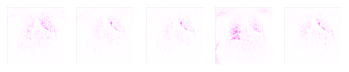

In [165]:
imshow_samples(sample_0,"integrated_gradient")

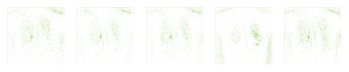

In [166]:
imshow_samples(sample_1,"integrated_gradient")

#### 3.2.1 Allgemeine Alanlyse

##### 3.2.1.1 Entropy

In [167]:
ig_results = load_wdCOM(df,"integrated_gradient")

KeyboardInterrupt: 

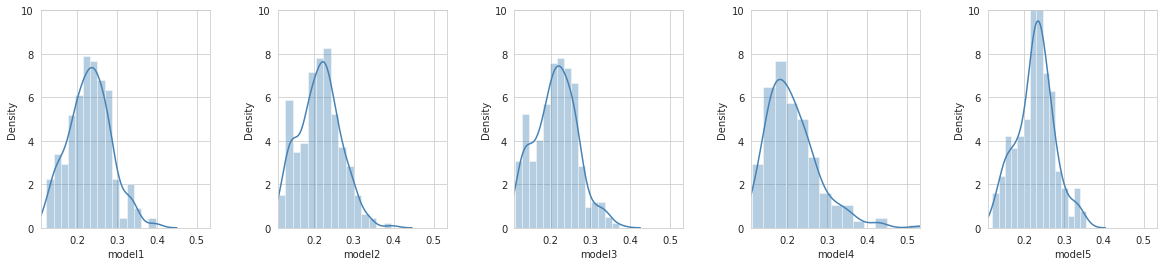

In [49]:
import warnings
warnings.filterwarnings("ignore")
plot_dist(ig_results,"steelblue",10)

<AxesSubplot:>

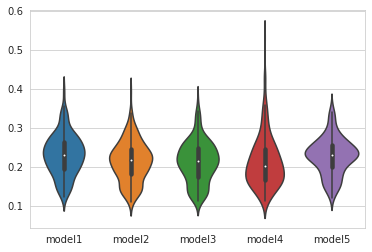

In [56]:
df_ig_results = pd.DataFrame(ig_results)
sns.violinplot(data=df_ig_results[["model1", "model2","model3","model4","model5"]])

Man erkennt an den Histogrammen, dass sich die Modelle leicht untefscheiden, allerdings besitzt Modell Nr 4 eine andere Verteilung.

##### 2.2.1.2 D of COM

In [50]:
ig_results_entropy = load_entropy(df,"integrated_gradient")

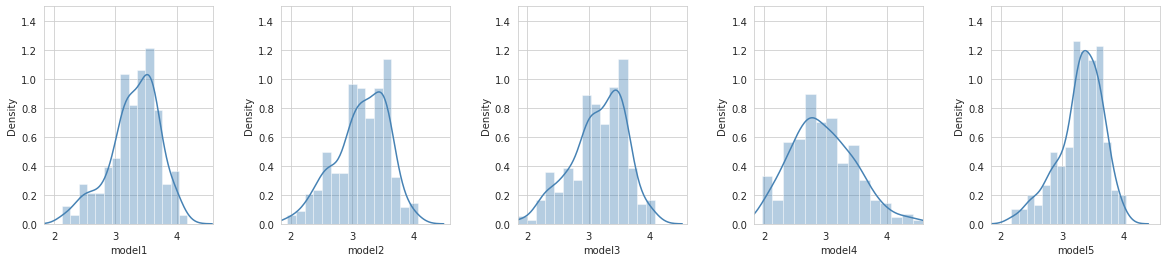

In [59]:
plot_dist(ig_results_entropy,"steelblue",1.5)

<AxesSubplot:>

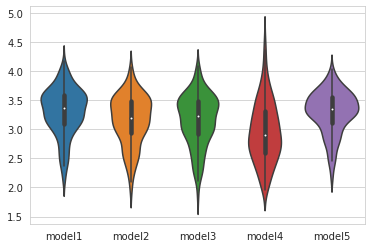

In [60]:
df_ig_results_entropy = pd.DataFrame(ig_results_entropy)
sns.violinplot(data=df_ig_results_entropy[["model1", "model2","model3","model4","model5"]])

Auch hier ist ersichtlich, dass sich Modell Nr. 4 unterscheidet.

### 3.2.2 Analyse der Labels
#### 3.2.2.1 Analyse Cardiomegly
Als nächstes wird für Modell Nr.1 eine genauere Analyse durchgeführt. Es soll unterschieden werden, wie die Labels abschgeschnitten haben.

In [85]:
df_m1 = pd.read_csv(data_path+f"xai/nih/integrated_gradient/heat_map/model1/results.csv").iloc[:,1:]
df_m1_0 = df_m1[df_m1["Finding Label"]==0]
df_m1_1 = df_m1[df_m1["Finding Label"]==1]
df_m1_c0 =  df_m1[df_m1["Finding Label"]==df_m1["prdicted"]]
df_m1_c1 =  df_m1[df_m1["Finding Label"]!=df_m1["prdicted"]]

In [86]:
ig_results_0 = load_wdCOM(df_m1_0,"integrated_gradient")
ig_results_entropy_0 = load_entropy(df_m1_0,"integrated_gradient")

##### 3.2.2.1.1 Entropy

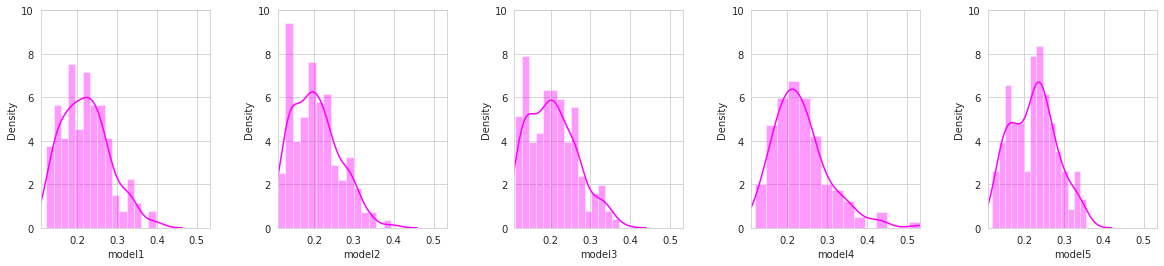

In [87]:
plot_dist(ig_results_0,colors[0],10)

<AxesSubplot:>

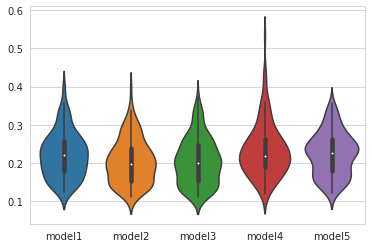

In [88]:
df_ig_results_0 = pd.DataFrame(ig_results_0)
sns.violinplot(data=df_ig_results_0[["model1", "model2","model3","model4","model5"]])

##### 3.2.2.1.2 D of COM

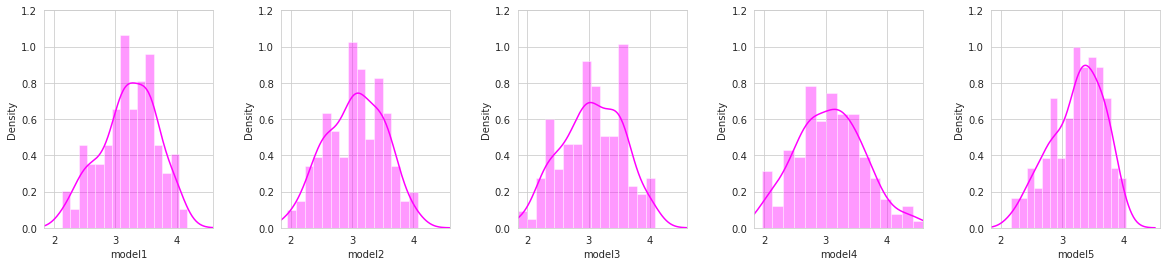

In [91]:
plot_dist(ig_results_entropy_0,colors[0],1.2)

<AxesSubplot:>

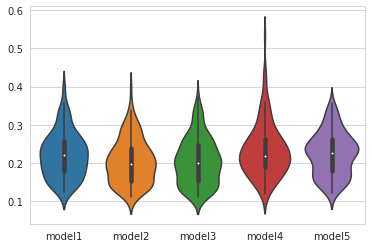

In [92]:
df_ig_results_0 = pd.DataFrame(ig_results_0)
sns.violinplot(data=df_ig_results_0[["model1", "model2","model3","model4","model5"]])

#### 3.2.2.2 Analyse Prneumothorax
##### 3.2.2.1.1 Entropy

In [94]:
ig_results_1 = load_wdCOM(df_m1_1,"integrated_gradient")
ig_results_entropy_1 = load_entropy(df_m1_1,"integrated_gradient")

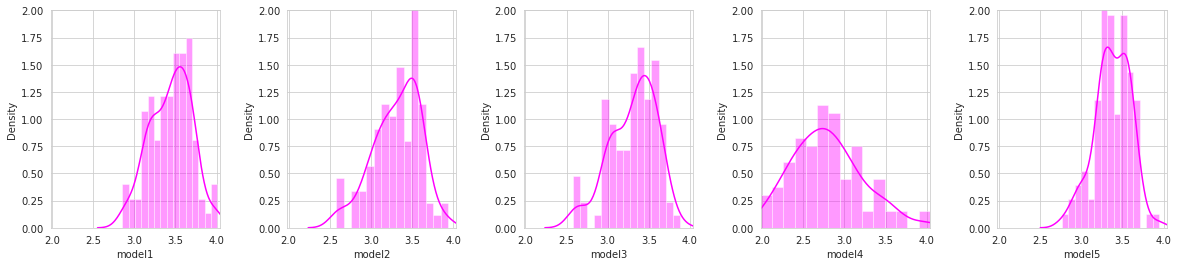

In [101]:
plot_dist(ig_results_entropy_1,colors[0],2)

<AxesSubplot:>

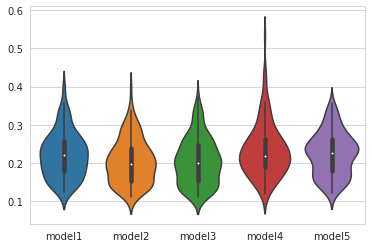

In [78]:
df_ig_results_0 = pd.DataFrame(ig_results_0)
sns.violinplot(data=df_ig_results_0[["model1", "model2","model3","model4","model5"]])

##### 3.2.2.1.2 D of COM

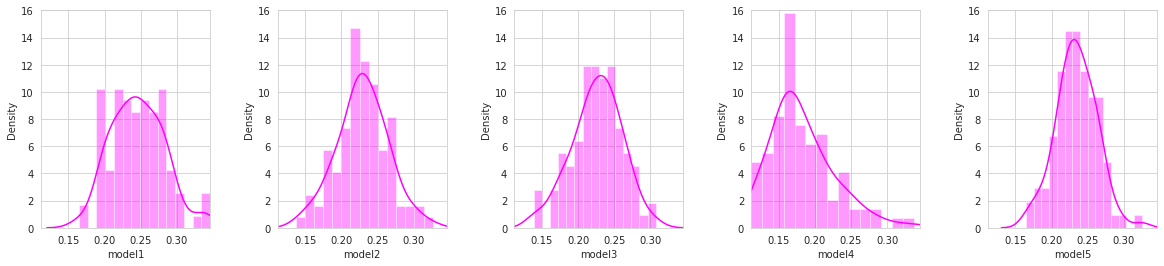

In [80]:
plot_dist(ig_results_1,colors[0],16)

<AxesSubplot:>

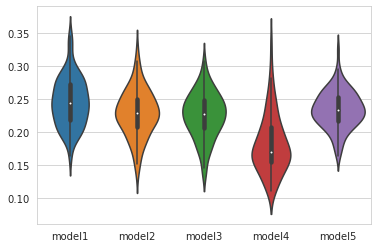

In [82]:
df_ig_results_1 = pd.DataFrame(ig_results_1)
sns.violinplot(data=df_ig_results_1[["model1", "model2","model3","model4","model5"]])

### 3.2.3 Unterscheidung zwischen richtigen und falsch Predicteten Modellen
#### 3.2.3.1 Analyse Correct
##### 3.2.3.1.1 Entropy


In [71]:
ig_results_c0 = load_wdCOM(df_m1_c0,"integrated_gradient")
ig_results_entropy_c0 = load_entropy(df_m1_c0,"integrated_gradient")

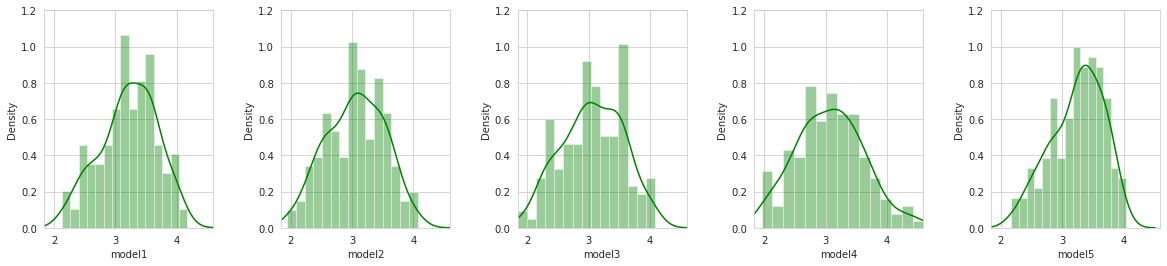

In [96]:
plot_dist(ig_results_entropy_0,"green",1.2)

<AxesSubplot:>

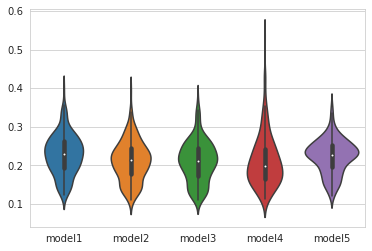

In [97]:
df_ig_results_entropy_c0 = pd.DataFrame(ig_results_c0)
sns.violinplot(data=df_ig_results_entropy_c0[["model1", "model2", "model3", "model4", "model5"]])

##### 3.2.2.1.1 D of COM

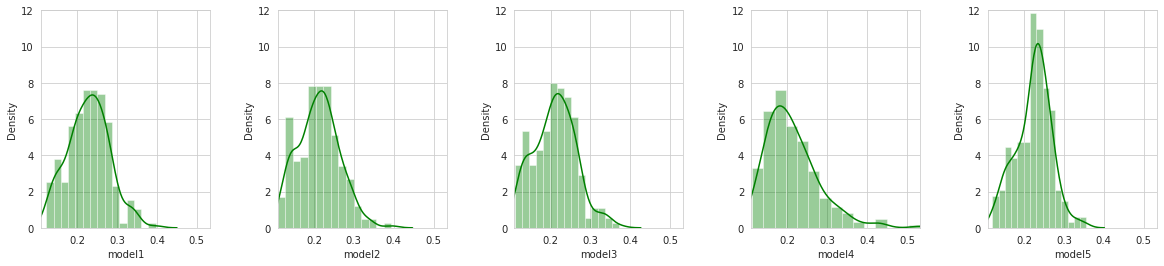

In [100]:
plot_dist(ig_results_c0, "green", 12)

<AxesSubplot:>

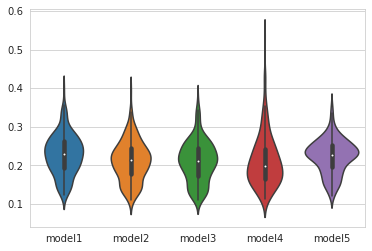

In [102]:
df_ig_results_c0 = pd.DataFrame(ig_results_c0)
sns.violinplot(data=df_ig_results_c0[["model1", "model2","model3","model4","model5"]])

#### 3.2.2.1.1 Analyse False Predicted
##### 3.2.3.1.1 Entropy

In [103]:
ig_results_c1 = load_wdCOM(df_m1_c1,"integrated_gradient")
ig_results_entropy_c1 = load_entropy(df_m1_c1,"integrated_gradient")

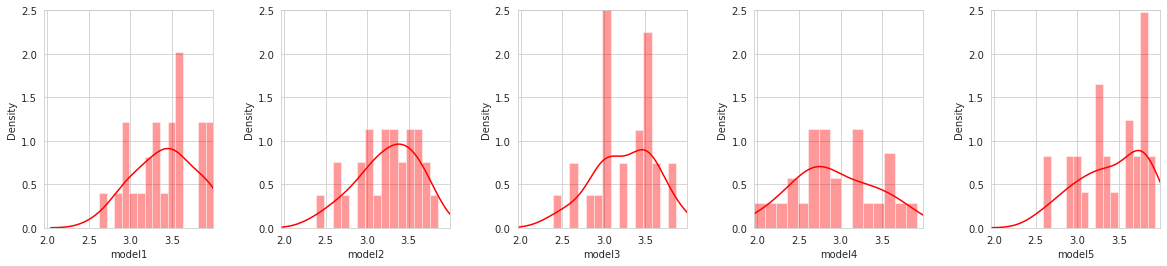

In [107]:
plot_dist(ig_results_entropy_c1,"red",2.5)

<AxesSubplot:>

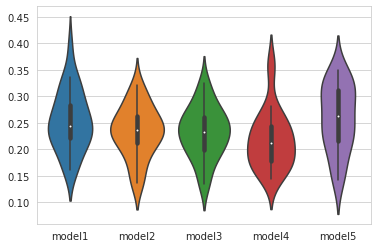

In [105]:
df_ig_results_c1 = pd.DataFrame(ig_results_c1)
sns.violinplot(data=df_ig_results_c1[["model1", "model2","model3","model4","model5"]])

##### 3.2.3.1.1 D of COM

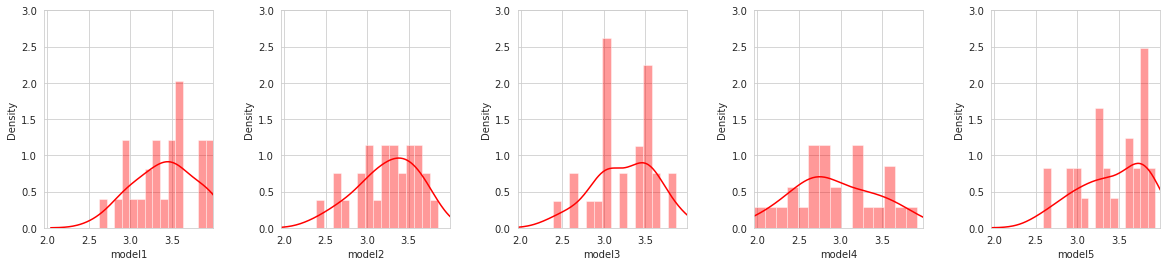

In [109]:
plot_dist(ig_results_c1,"red",3)

<AxesSubplot:>

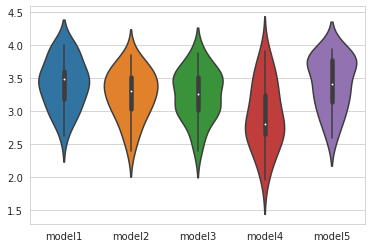

In [110]:
df_ig_results_c1 = pd.DataFrame(ig_results_c1)
sns.violinplot(data=df_ig_results_c1[["model1", "model2","model3","model4","model5"]])


## 4.0 Gradient SHAP

Gradient SHAP ist eine Gradientenmethode zur Berechnung von SHAP-Werten, die auf den in der kooperativen Spieltheorie vorgeschlagenen Shapley-Werten beruhen. Gradient SHAP fügt jeder Eingabeprobe mehrfach Gaußsches Rauschen hinzu, wählt einen zufälligen Punkt entlang des Pfades zwischen Basislinie und Eingabe und berechnet den Gradienten der Ausgaben in Bezug auf diese ausgewählten Zufallspunkte. Die endgültigen SHAP-Werte stellen den Erwartungswert der Gradienten * (Eingänge - Basislinien) dar.

Die berechneten Attributionen approximieren die SHAP-Werte unter der Annahme, dass die Input-Merkmale unabhängig sind und dass das Erklärungsmodell zwischen den Inputs und den gegebenen Basislinien linear ist.


### 4.1 Laden der Captum Funktion


In [111]:
def run_gradient_shap(model,input,pred_label_idx,color,transformed_img,methode = "heat_map"):
    gradient_shap = GradientShap(model)

    # Defining baseline distribution of images
    rand_img_dist = torch.cat([input * 0, input * 255])

    attributions_gs = gradient_shap.attribute(input,
                                              n_samples=50,
                                              stdevs=0.0001,
                                              baselines=rand_img_dist,
                                              target=pred_label_idx)

    # create custom colormap for visualizing the result
    default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                     [(0, '#ffffff'),
                                                      (1, color)], N=256)

    p,f = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 methods=[methode],
                                 signs=['positive'],
                                 cmap=default_cmap,
                                 show_colorbar=False,
                                 fig_size=(5,5),
                                 alpha_overlay=0.5)
    return p

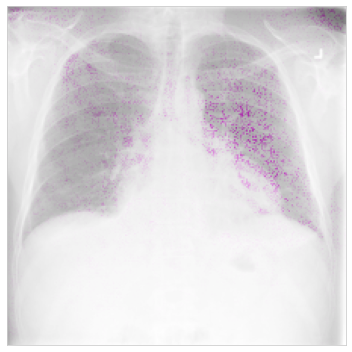

In [112]:
_ = run_gradient_shap(model_list[0],
                        sample_0_results["input"],
                        sample_0_results["pred_label_idx"],
                        colors[0],
                        sample_0_results["transformed_img"],
                        methode="blended_heat_map"
                        )

In [113]:
#labels = ["Cardiomaly", "Pneomothorax", ]
# load pictures from bbox dataset
def save_all_picutures_gradient_shap(method):
    for m in range(len(model_list)):
        direcory_xai = f"../../../data/xai/nih/gradient_shap"
        if not os.path.exists(direcory_xai):
            os.makedirs(direcory_xai)

        df_results_all    = df.copy()
        results_entropy   = []
        results_predicted = []

        for i in df["path"].tolist():

            direcory_method = f"{direcory_xai}/{method}"
            if not os.path.exists(direcory_method):
                os.makedirs(direcory_method)

            direcory_model = f"{direcory_method}/model{m+1}"
            if not os.path.exists(direcory_model):
                os.makedirs(direcory_model)

            results = load_image(f"{i}",model_list[m])
            results_entropy.append(entropy("../../../data/Chest/" + i))
            results_predicted.append(results['pred_label_idx'])


            p = run_gradient_shap(model=model_list[m],
                                        input=results["input"],
                                        pred_label_idx=results["pred_label_idx"],
                                        color=colors[results["truth_label_idx"]],
                                        transformed_img=results["transformed_img"],
                                        methode = method
                                        )
            p.savefig(f"{direcory_model}/{i[18:]}", bbox_inches="tight",pad_inches=0)

        df_results_all["entropy"]  = results_entropy
        df_results_all["predicted"] = results_predicted
        df_results_all.to_csv(f"../../../data/xai/nih/gradient_shap/heat_map/model{m+1}/results.csv")

### 4.2 Abspeichern der Heatmaps

In [114]:
%%capture
#save_all_picutures_gradient_shap(method="heat_map")

In [115]:
%%capture
#save_all_picutures_gradient_shap(method="blended_heat_map")

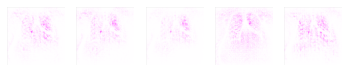

In [116]:
imshow_samples(sample_0,"gradient_shap")

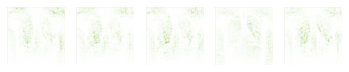

In [117]:
imshow_samples(sample_1,"gradient_shap")

### 4.3 Vergleich der Modelle
#### 4.3.1 Allgemeine Analyse
##### 4.3.1.1 Entropy

In [118]:
gs_results_entropy = load_entropy(df, "gradient_shap")
gs_results = load_wdCOM(df, "gradient_shap")

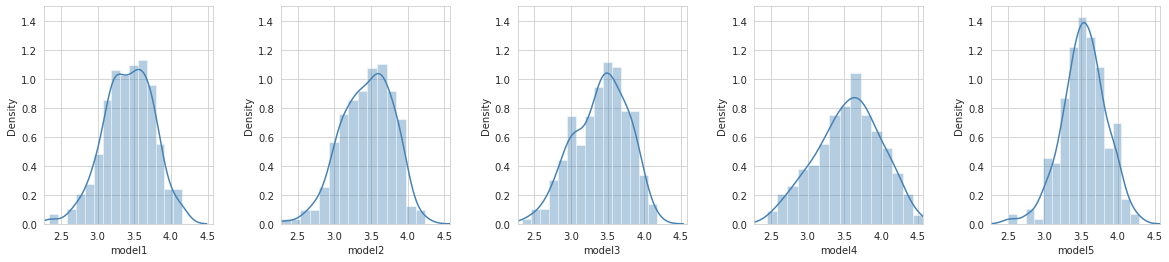

In [120]:
plot_dist(gs_results_entropy,"steelblue",1.5)

<AxesSubplot:>

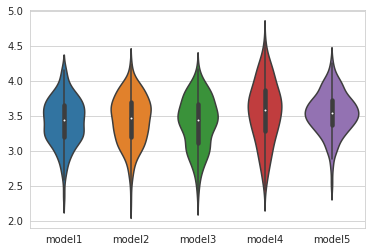

In [123]:
df_gs_results_entropy = pd.DataFrame(gs_results_entropy)
sns.violinplot(data=df_gs_results_entropy[["model1", "model2","model3","model4","model5"]])

##### 3.3.1.2 D of COM

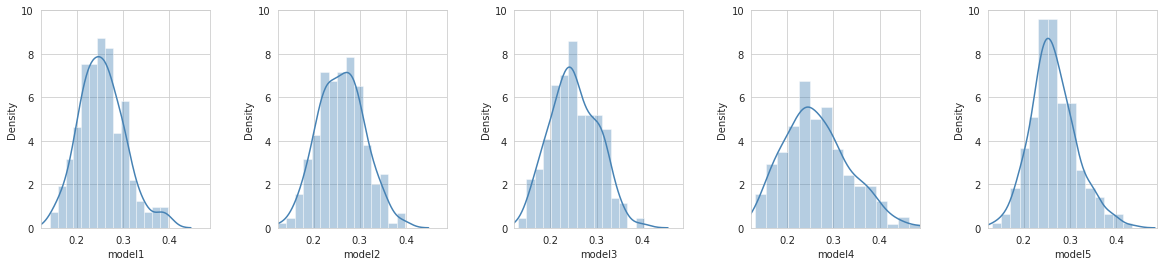

In [124]:
plot_dist(gs_results,"steelblue",10)

<AxesSubplot:>

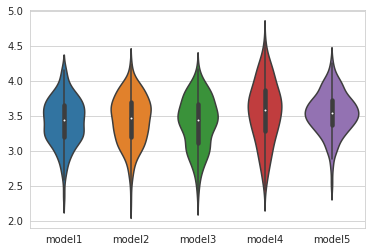

In [125]:
df_gs_results_entropy = pd.DataFrame(gs_results_entropy)
sns.violinplot(data=df_gs_results_entropy[["model1", "model2","model3","model4","model5"]])

In [127]:
gs_results_0 = load_wdCOM(df_m1_0, "gradient_shap")
gs_results_entropy_0 = load_entropy(df_m1_0, "gradient_shap")

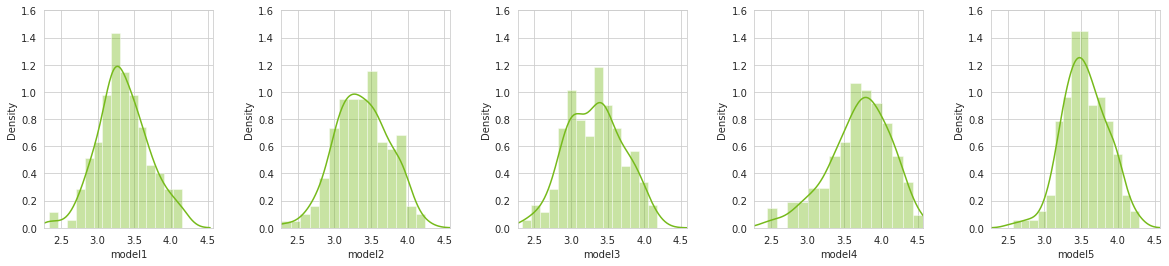

In [129]:
plot_dist(gs_results_entropy_0,colors[1],1.6)

<AxesSubplot:>

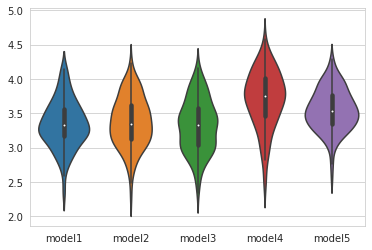

In [130]:
df_gs_results_entropy_0 = pd.DataFrame(gs_results_entropy_0)
sns.violinplot(data=df_gs_results_entropy_0[["model1", "model2","model3","model4","model5"]])

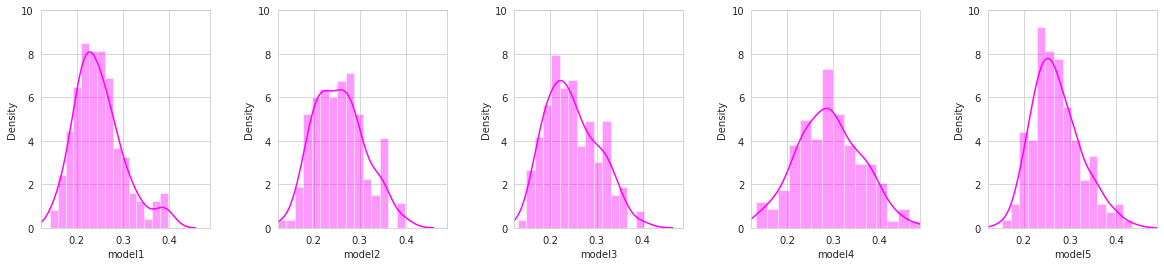

In [131]:
plot_dist(gs_results_0,colors[0],10)

<AxesSubplot:>

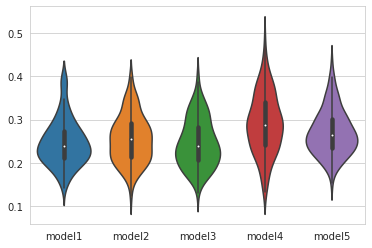

In [132]:
df_gs_results_0 = pd.DataFrame(gs_results_0)
sns.violinplot(data=df_gs_results_0[["model1", "model2","model3","model4","model5"]])

#### 4.3.2 Unterscheidung zwischen richtig predictieten Ergebnissen
##### 4.3.2.1 Richtig
###### 4.3.2.1.1 Entropy

In [133]:
gs_results_c0 = load_wdCOM(df_m1_c0, "gradient_shap")
gs_results_entropy_c0 = load_entropy(df_m1_c0, "gradient_shap")

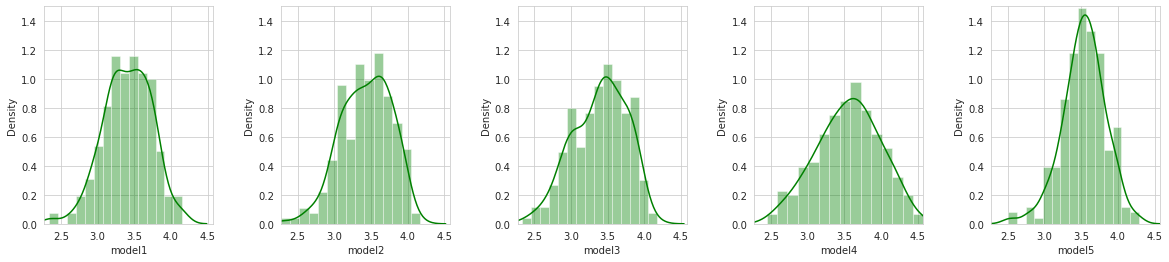

In [137]:
plot_dist(gs_results_entropy_c0,"green",1.5)

<AxesSubplot:>

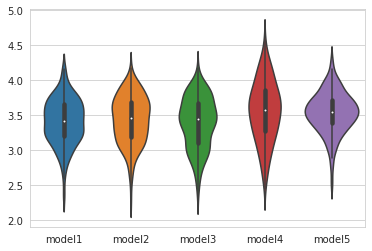

In [138]:
df_gs_results_entropy_c0 = pd.DataFrame(gs_results_entropy_c0)
sns.violinplot(data=df_gs_results_entropy_c0[["model1", "model2","model3","model4","model5"]])

###### 4.3.2.1.2 D of COM

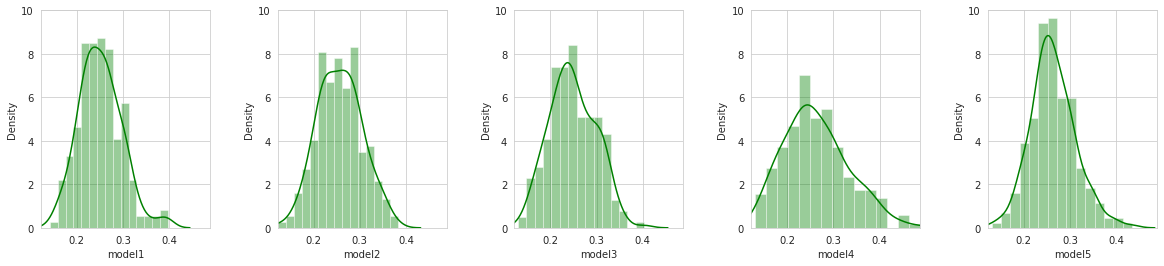

In [139]:
plot_dist(gs_results_c0,"green",10)

<AxesSubplot:>

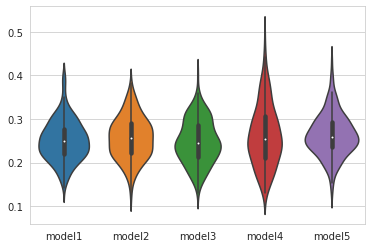

In [140]:
df_gs_results_c0 = pd.DataFrame(gs_results_c0)
sns.violinplot(data=df_gs_results_c0[["model1", "model2","model3","model4","model5"]])

##### 4.3.3.2 Falsch
###### 4.3.3.2.1 Entropy

In [141]:
gs_results_c1 = load_wdCOM(df_m1_c1, "gradient_shap")
gs_results_entropy_c1 = load_entropy(df_m1_c1, "gradient_shap")

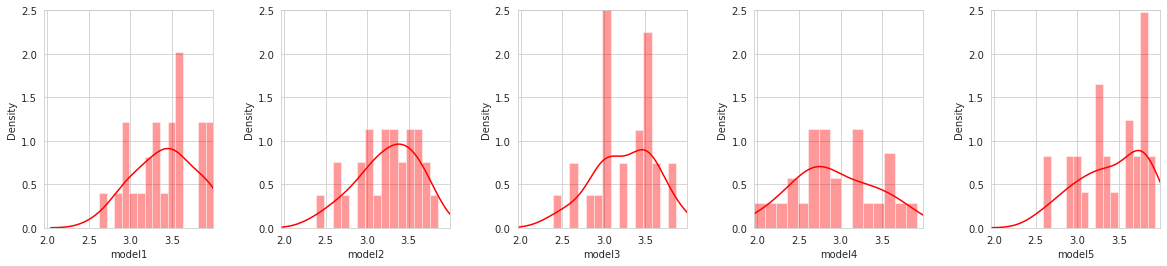

In [143]:
plot_dist(ig_results_entropy_c1,"red",2.5)

<AxesSubplot:>

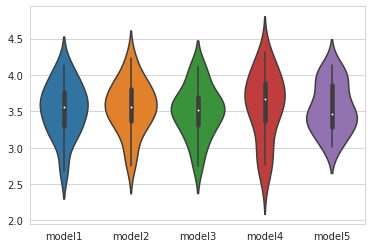

In [144]:
df_gs_results_entropy_c1 = pd.DataFrame(gs_results_entropy_c1)
sns.violinplot(data=df_gs_results_entropy_c1[["model1", "model2", "model3", "model4", "model5"]])

###### 4.3.3.2.2 D of COM

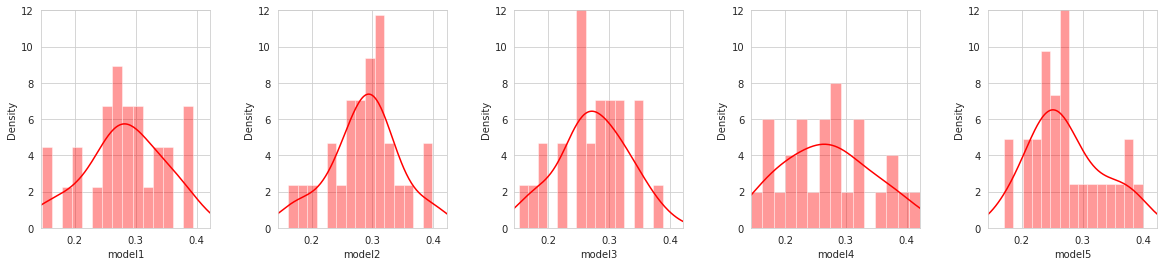

In [147]:
plot_dist(gs_results_c1, "red", 12)

<AxesSubplot:>

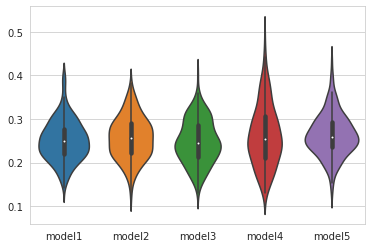

In [148]:
df_gs_results_c0 = pd.DataFrame(gs_results_c0)
sns.violinplot(data=df_gs_results_c0[["model1", "model2", "model3", "model4", "model5"]])

## 5.0 Occlusion SHAP
   Okklusion ist ein **störungsbasierter Ansatz** zur Berechnung der Attribution, bei dem jede zusammenhängende rechteckige Region durch eine gegebene Basislinie/Referenz ersetzt wird und die Differenz im Output berechnet wird. Bei Merkmalen, die sich in mehreren Regionen (Hyperrechtecken) befinden, werden die entsprechenden Ausgabedifferenzen gemittelt, um die Attribution für das betreffende Merkmal zu berechnen.
   Okklusion ist am nützlichsten in Fällen wie Bildern, wo die Pixel in einer zusammenhängenden rechteckigen Region wahrscheinlich stark korreliert sind.


### 5.1 Laden der Captum Funktion

In [149]:
def run_occulusion(model,input,pred_label_idx,color,transformed_img,methode = "heat_map"):
    occlusion = Occlusion(model)
    attributions_occ = occlusion.attribute(input,
                                           strides = (3, 8, 8),
                                           target=pred_label_idx,
                                           sliding_window_shapes=(3,15, 15),
                                           baselines=0)
        # create custom colormap for visualizing the result
    default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                     [(0, '#ffffff'),
                                                      (1, color)], N=256)


    p,f = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          methods=[methode],
                                          signs=['positive'],
                                          cmap=default_cmap,
                                          show_colorbar=False,
                                          fig_size=(5,5),
                                          alpha_overlay=0.5)
    return p

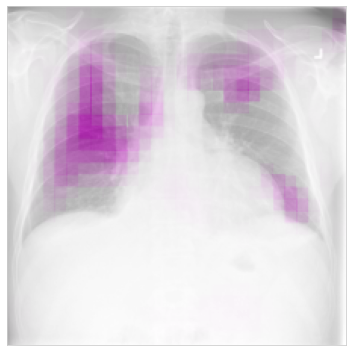

In [150]:
_ = run_occulusion(model_list[0],
                        sample_0_results["input"],
                        sample_0_results["pred_label_idx"],
                        colors[0],
                        sample_0_results["transformed_img"],
                        methode="blended_heat_map"
                        )

In [151]:
#labels = ["Cardiomaly", "Pneomothorax", ]
# load pictures from bbox dataset
def save_all_picutures_occlusion(method):
    for m in range(len(model_list)):
        direcory_xai = f"../../../data/xai/nih/occlusion"
        if not os.path.exists(direcory_xai):
            os.makedirs(direcory_xai)
        df_results_all    = df.copy()
        results_entropy   = []
        results_predicted = []
        for i in pd.read_csv("../../../data/Chest/BBox_List_2017_pneumo_cardio_lean.csv")["path"].tolist():

            direcory_method = f"{direcory_xai}/{method}"
            if not os.path.exists(direcory_method):
                os.makedirs(direcory_method)

            direcory_model = f"{direcory_method}/model{m+1}"
            if not os.path.exists(direcory_model):
                os.makedirs(direcory_model)

            results = load_image(f"{i}",model_list[m])
            results_entropy.append(entropy("../../../data/Chest/" + i))
            results_predicted.append(results['pred_label_idx'])

            p = run_occulusion(model=model_list[m],
                                        input=results["input"],
                                        pred_label_idx=results["pred_label_idx"],
                                        color=colors[results["truth_label_idx"]],
                                        transformed_img=results["transformed_img"],
                                        methode = method
                                        )
            p.savefig(f"{direcory_model}/{i[18:]}", bbox_inches="tight",pad_inches=0)


        df_results_all["entropy"]  = results_entropy
        df_results_all["predicted"] = results_predicted
        df_results_all.to_csv(f"../../../data/xai/nih/occlusion/heat_map/model{m+1}/results.csv")

### 5.2 Abspeichern der Heatmaps

In [152]:
%%capture
#save_all_picutures_occlusion(method="heat_map")

In [153]:
%%capture
#save_all_picutures_occlusion(method="blended_heat_map")

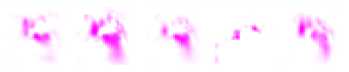

In [154]:
imshow_samples(sample_0,"occlusion")

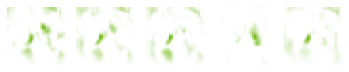

In [155]:
imshow_samples(sample_1,"occlusion")

### 5.3 Vergleich der Modelle
#### 5.3.1 Allgemeine Analyse
##### 5.3.1.1 Entropy

In [156]:
occ_results_entropy = load_entropy(df, "occlusion")
occ_results = load_wdCOM(df, "occlusion")

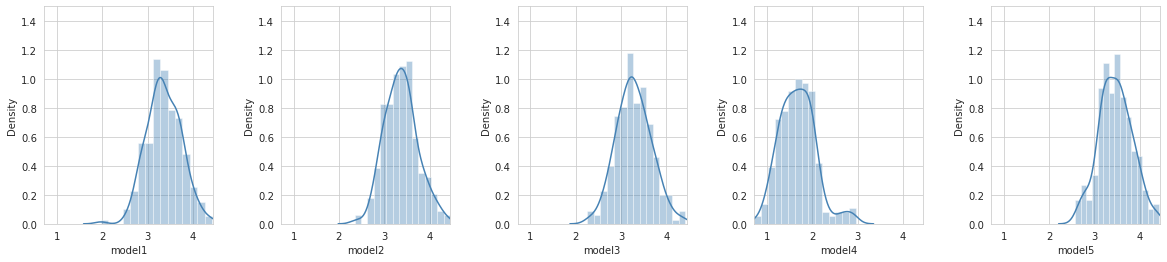

In [157]:
plot_dist(occ_results_entropy, "steelblue", 1.5)

<AxesSubplot:>

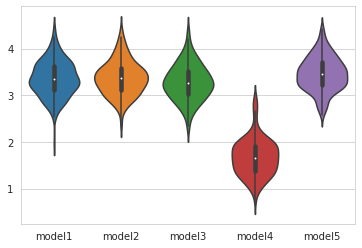

In [158]:
df_occ_results_entropy = pd.DataFrame(occ_results_entropy)
sns.violinplot(data=df_occ_results_entropy[["model1", "model2", "model3", "model4", "model5"]])

##### 5.3.1.2 D of COM

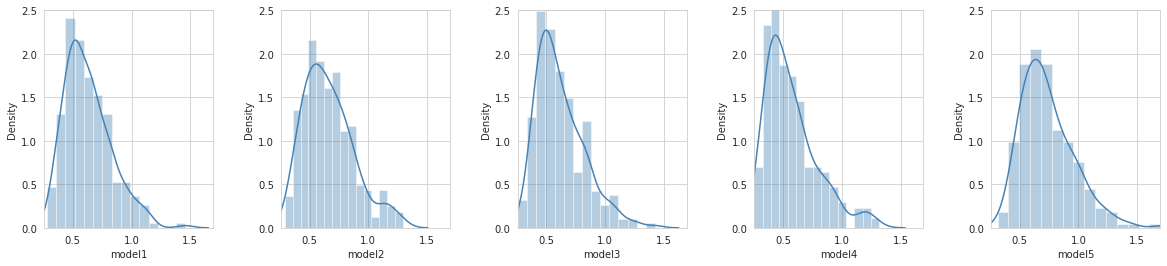

In [160]:
plot_dist(occ_results, "steelblue", 2.5)

<AxesSubplot:>

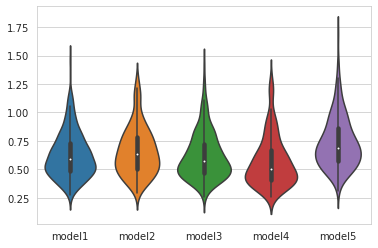

In [169]:
df_occ_results = pd.DataFrame(occ_results)
sns.violinplot(data=df_occ_results[["model1", "model2", "model3", "model4", "model5"]])

#### 5.3.2 Analyse der Labels
##### 5.3.2.1 Cardiomegaly
###### 5.3.2.1.1 Entropie

In [162]:
occ_results_0 = load_wdCOM(df_m1_0, "occlusion")
occ_results_entropy_0 = load_entropy(df_m1_0, "occlusion")

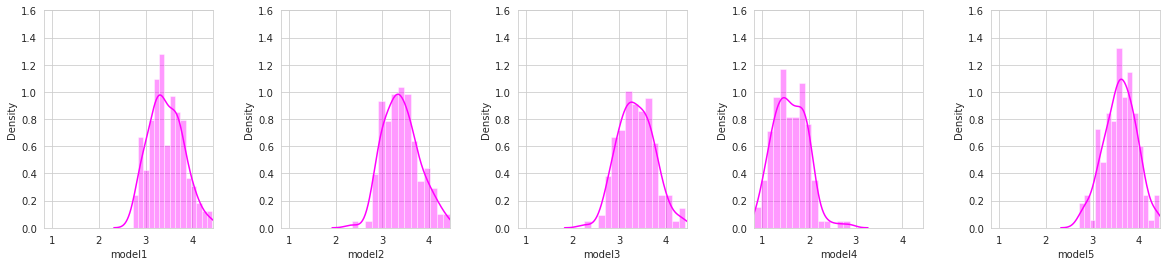

In [168]:
plot_dist(occ_results_entropy_0, colors[0], 1.6)

<AxesSubplot:>

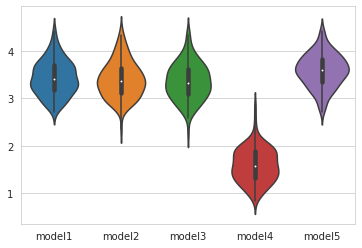

In [170]:
df_occ_results_entropy_0 = pd.DataFrame(occ_results_entropy_0)
sns.violinplot(data=df_occ_results_entropy_0[["model1", "model2", "model3", "model4", "model5"]])

###### 5.2.2.1.2 D of COM


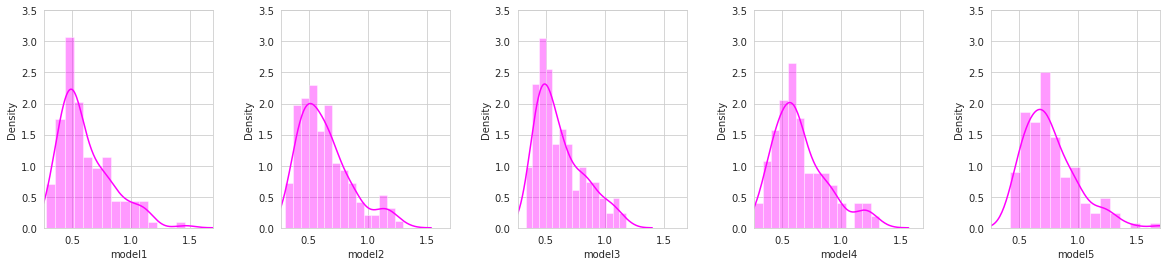

In [172]:
plot_dist(occ_results_0, colors[0], 3.5)

<AxesSubplot:>

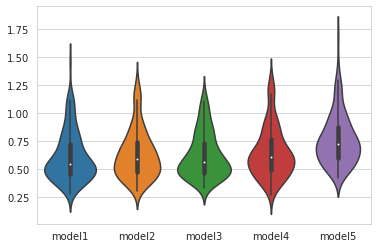

In [173]:
df_occ_results_0 = pd.DataFrame(occ_results_0)
sns.violinplot(data=df_occ_results_0[["model1", "model2", "model3", "model4", "model5"]])

##### 5.2.2.2 Pneumothorax
###### 5.2.2.2.1 Entropie

In [174]:
occ_results_1 = load_wdCOM(df_m1_1, "occlusion")
occ_results_entropy_1 = load_entropy(df_m1_1, "occlusion")

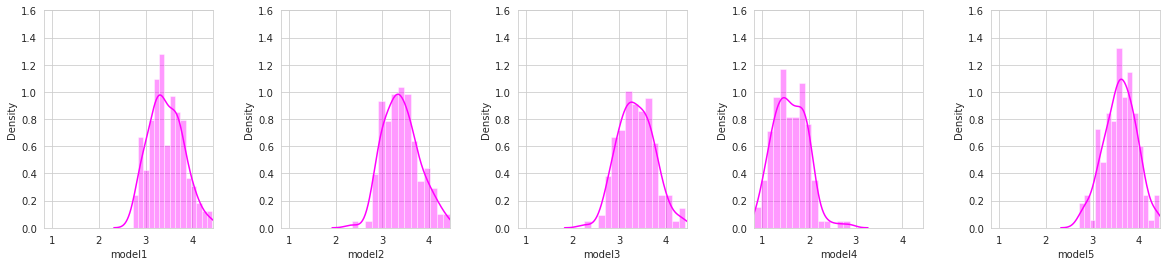

In [177]:
plot_dist(occ_results_entropy_0, colors[0], 1.6)

<AxesSubplot:>

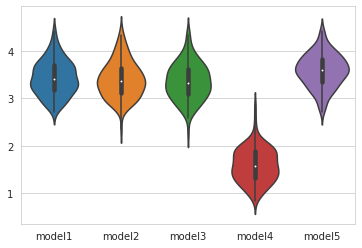

In [178]:
df_occ_results_entropy_0 = pd.DataFrame(occ_results_entropy_0)
sns.violinplot(data=df_occ_results_entropy_0[["model1", "model2", "model3", "model4", "model5"]])

###### 5.2.2.2.2 D of COM

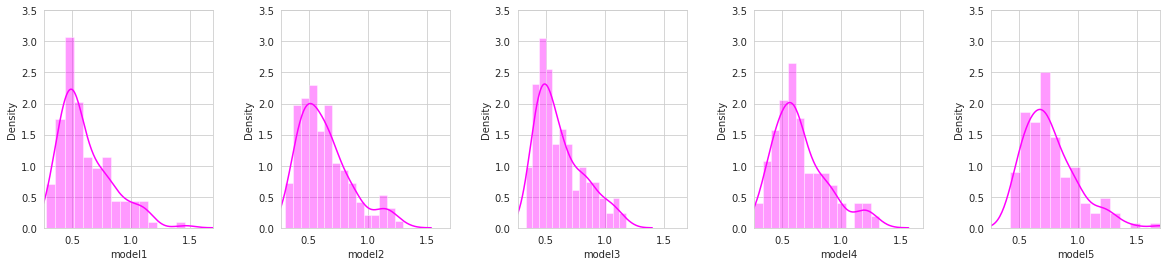

In [180]:
plot_dist(occ_results_0, colors[0], 3.5)

<AxesSubplot:>

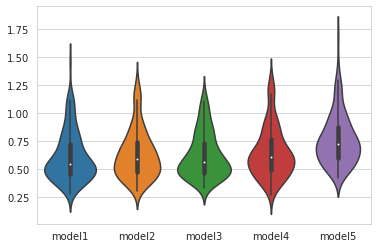

In [181]:
df_gs_results_0 = pd.DataFrame(occ_results_0)
sns.violinplot(data=df_gs_results_0[["model1", "model2", "model3", "model4", "model5"]])

#### 5.3.3 Analyse der Predictions
##### 5.3.3.1 Richtig
###### 5.3.3.1.1 Entropie

In [182]:
### Unterscheidung zwischen richtigen und falsch Predicteten Modellen
occ_results_c0 = load_wdCOM(df_m1_c0, "occlusion")
occ_results_entropy_c0 = load_entropy(df_m1_c0, "occlusion")

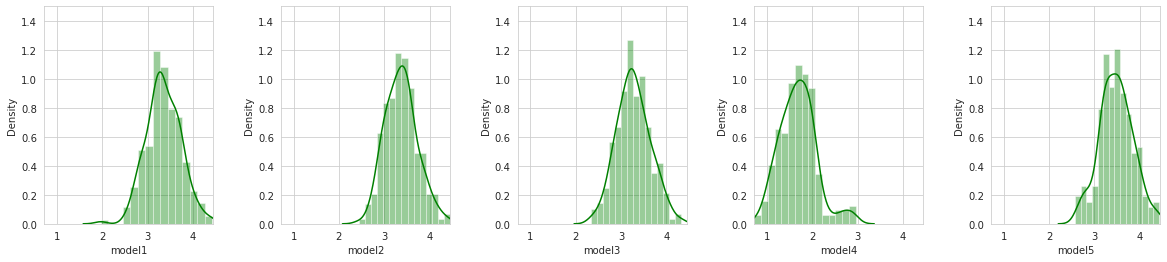

In [183]:
plot_dist(occ_results_entropy_c0, "green", 1.5)

<AxesSubplot:>

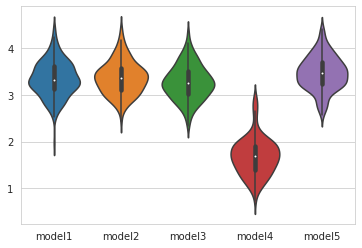

In [184]:
df_occ_results_entropy_c0 = pd.DataFrame(occ_results_entropy_c0)
sns.violinplot(data=df_occ_results_entropy_c0[["model1", "model2", "model3", "model4", "model5"]])

###### 5.3.3.1.1 D of COM

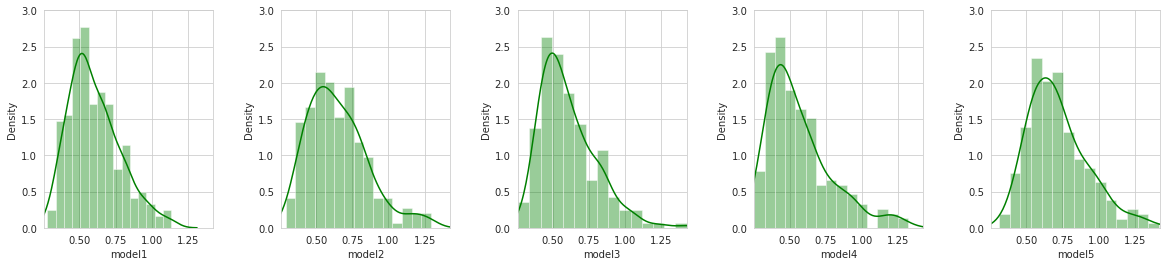

In [189]:
plot_dist(occ_results_c0, "green", 3)

<AxesSubplot:>

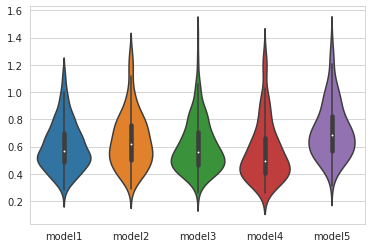

In [186]:
df_occ_results_c0 = pd.DataFrame(occ_results_c0)
sns.violinplot(data=df_occ_results_c0[["model1", "model2", "model3", "model4", "model5"]])

##### 5.3.3.2 Falsch
###### 5.3.3.2.1 Entropie

In [190]:
occ_results_c1 = load_wdCOM(df_m1_c1, "occlusion")
occ_results_entropy_c1 = load_entropy(df_m1_c1, "gradient_shap")

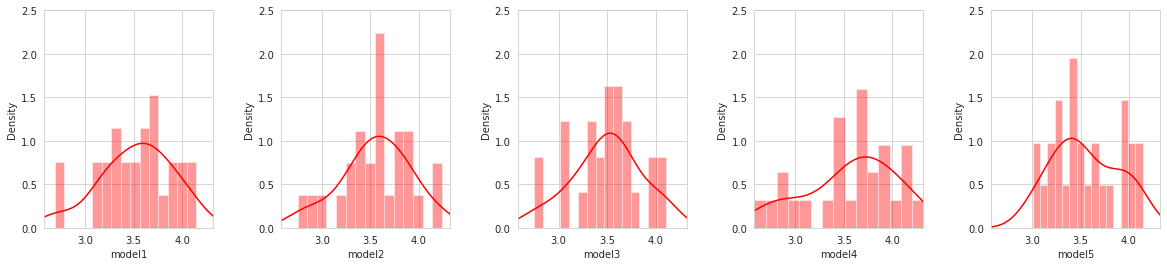

In [191]:
plot_dist(occ_results_entropy_c1, "red", 2.5)

<AxesSubplot:>

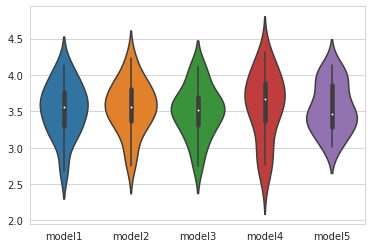

In [192]:
df_occ_results_entropy_c1 = pd.DataFrame(occ_results_entropy_c1)
sns.violinplot(data=df_occ_results_entropy_c1[["model1", "model2", "model3", "model4", "model5"]])

###### 5.3.3.1.2 D of COM

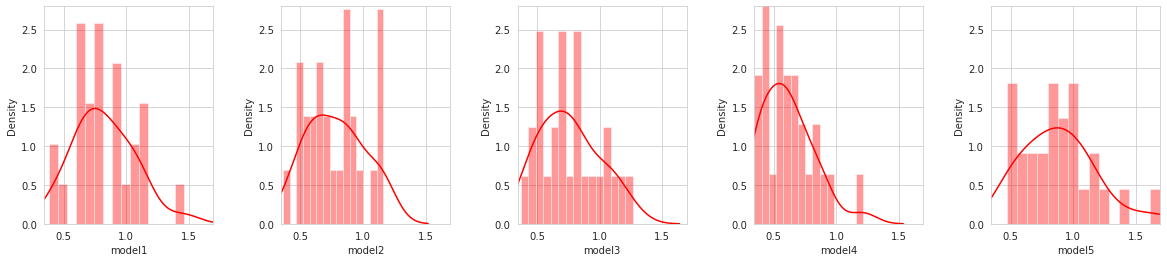

In [195]:
plot_dist(occ_results_c1, "red", 2.8)

<AxesSubplot:>

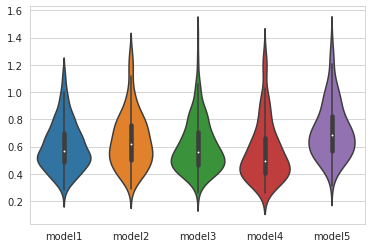

In [196]:
df_occ_results_c1 = pd.DataFrame(occ_results_c0)
sns.violinplot(data=df_occ_results_c0[["model1", "model2", "model3", "model4", "model5"]])

## 6.0 Noise Tunnel
### 6.1 Laden der Captumfunktion

In [197]:
def run_ig_noisetunnel(model,input,pred_label_idx,color,transformed_img,methode = "heat_map"):

    integrated_gradients = IntegratedGradients(model)
    noise_tunnel = NoiseTunnel(integrated_gradients)

    attributions_occ_nt = noise_tunnel.attribute(input, nt_type='smoothgrad_sq', target=pred_label_idx)

        # create custom colormap for visualizing the result
    default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                     [(0, '#ffffff'),
                                                      (1, color)], N=256)


    p,f = viz.visualize_image_attr_multiple(np.transpose(attributions_occ_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          methods=[methode],
                                          signs=['positive'],
                                          cmap=default_cmap,
                                          show_colorbar=False,
                                          fig_size=(5,5),
                                          alpha_overlay=0.5)
    return p

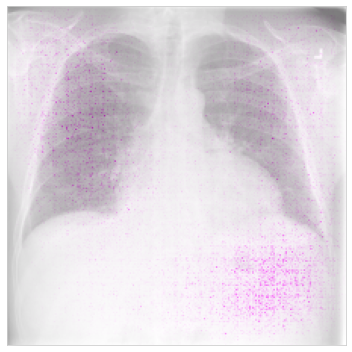

In [198]:
_ = run_ig_noisetunnel(model_list[0],
                               sample_0_results["input"],
                               sample_0_results["pred_label_idx"],
                               colors[0],
                               sample_0_results["transformed_img"],
                               methode="blended_heat_map"
                               )

In [199]:
#labels = ["Cardiomaly", "Pneomothorax", ]
# load pictures from bbox dataset
def save_all_picutures_noise_tunnel(method):
    for m in range(len(model_list)):
        direcory_xai = f"../../../data/xai/nih/noise_tunnel"
        if not os.path.exists(direcory_xai):
            os.makedirs(direcory_xai)

        df_results_all    = df.copy()
        results_predicted = []
        for i in pd.read_csv("../../../data/Chest/BBox_List_2017_pneumo_cardio_lean.csv")["path"].tolist():

            direcory_method = f"../../../data/xai/nih/noise_tunnel/{method}"
            if not os.path.exists(direcory_method):
                os.makedirs(direcory_method)

            direcory_model = f"../../../data/xai/nih/noise_tunnel/{method}/model{m+1}"
            if not os.path.exists(direcory_model):
                os.makedirs(direcory_model)

            results = load_image(f"{i}",model_list[m])
            results_predicted.append(results['pred_label_idx'])

            p = run_ig_noisetunnel(model=model_list[m],
                                        input=results["input"],
                                        pred_label_idx=results["pred_label_idx"],
                                        color=colors[results["truth_label_idx"]],
                                        transformed_img=results["transformed_img"],
                                        methode = method
                                        )
            p.savefig(f"{direcory_model}/{i[18:]}", bbox_inches="tight",pad_inches=0)

        df_results_all["predicted"] = results_predicted
        df_results_all.to_csv(f"../../../data/xai/nih/noise_tunnel/{method}/model{m+1}/results.csv")

### 6.2 Abspeichern der Heatmaps

In [200]:
%%capture
#save_all_picutures_noise_tunnel(method="heat_map")

In [201]:
%%capture
#save_all_picutures_noise_tunnel(method="blended_heat_map")

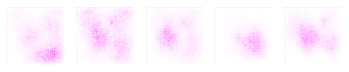

In [202]:
imshow_samples(sample_0,"noise_tunnel")

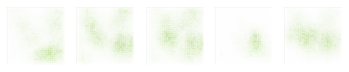

In [203]:
imshow_samples(sample_1,"noise_tunnel")

### 6.3 Vergleich der Modelle
#### 6.3.1 Allgemeine Analyse
##### 6.3.1.1 Entropy

In [215]:
nt_results = load_wdCOM(df, "noise_tunnel")
nt_results_entropy = load_entropy(df, "noise_tunnel")

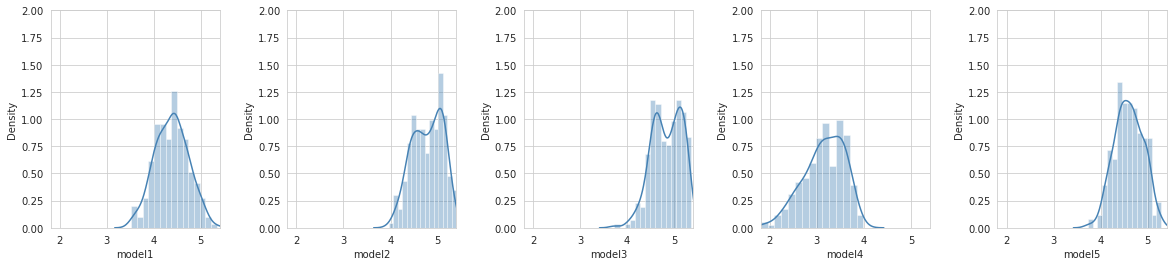

In [217]:
plot_dist(nt_results_entropy,"steelblue",2)

<AxesSubplot:>

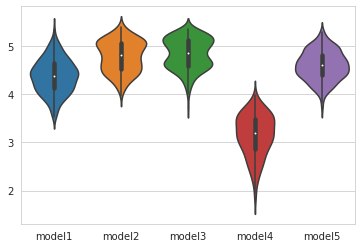

In [218]:
df_nt_results_entropy = pd.DataFrame(nt_results_entropy)
sns.violinplot(data=df_nt_results_entropy[["model1", "model2", "model3", "model4", "model5"]])

##### 6.3.1.2 D of COM

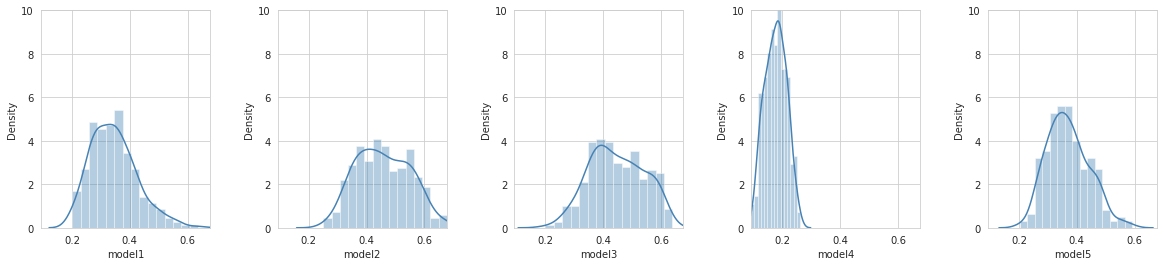

In [219]:
plot_dist(nt_results,"steelblue",10)

<AxesSubplot:>

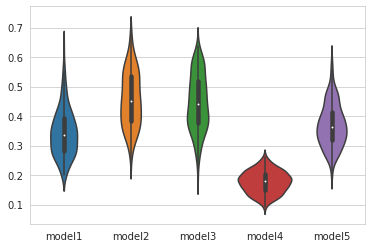

In [220]:
df_nt_results = pd.DataFrame(nt_results)
sns.violinplot(data=df_nt_results[["model1", "model2", "model3", "model4", "model5"]])

#### 6.3.2 Analyse der Labels
##### 6.3.2.1 Cardiomegaly
###### 6.3.2.1.1 Entropie

In [221]:
nt_results_0 = load_wdCOM(df_m1_0, "noise_tunnel")
nt_results_entropy_0 = load_entropy(df_m1_0, "noise_tunnel")

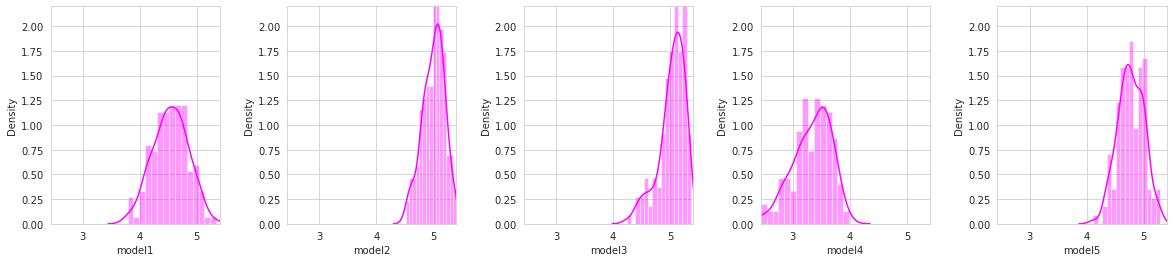

In [224]:
plot_dist(nt_results_entropy_0,colors[0],2.2)

<AxesSubplot:>

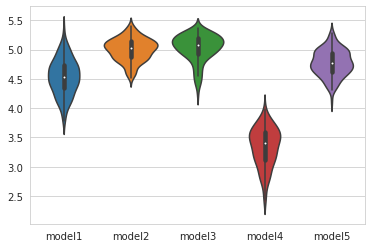

In [225]:
df_nt_results_entropy_0 = pd.DataFrame(nt_results_entropy_0)
sns.violinplot(data=df_nt_results_entropy_0[["model1", "model2", "model3", "model4", "model5"]])

###### 6.3.3.1.2 D of COM

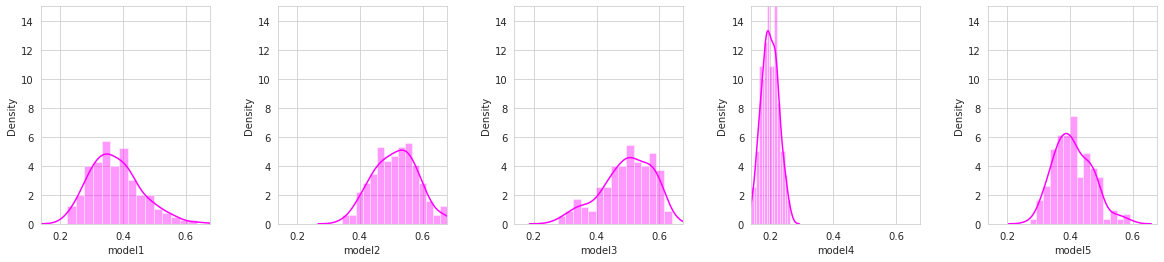

In [226]:
plot_dist(nt_results_0,colors[0],15)

<AxesSubplot:>

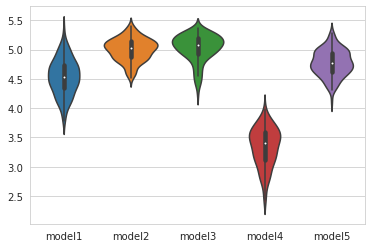

In [227]:
df_nt_results_entropy_0 = pd.DataFrame(nt_results_entropy_0)
sns.violinplot(data=df_nt_results_entropy_0[["model1", "model2", "model3", "model4", "model5"]])

##### 6.3.2.2 Pneuothorax
###### 6.3.2.2.1 Entropie

In [232]:
nt_results_1 = load_wdCOM(df_m1_1, "noise_tunnel")
nt_results_entropy_1 = load_entropy(df_m1_1, "noise_tunnel")

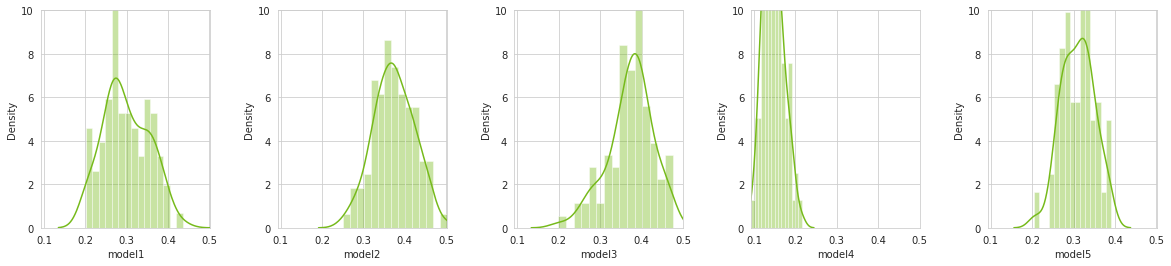

In [209]:
plot_dist(nt_results_entropy_1, colors[1], 10)

<AxesSubplot:>

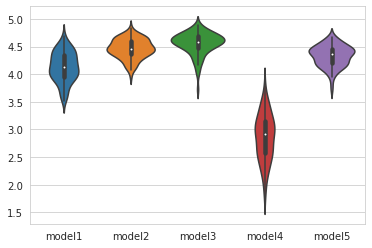

In [230]:
df_nt_results_entropy_1 = pd.DataFrame(nt_results_entropy_1)
sns.violinplot(data=df_nt_results_entropy_1[["model1", "model2", "model3", "model4", "model5"]])

###### 6.3.2.2.2 D of COM

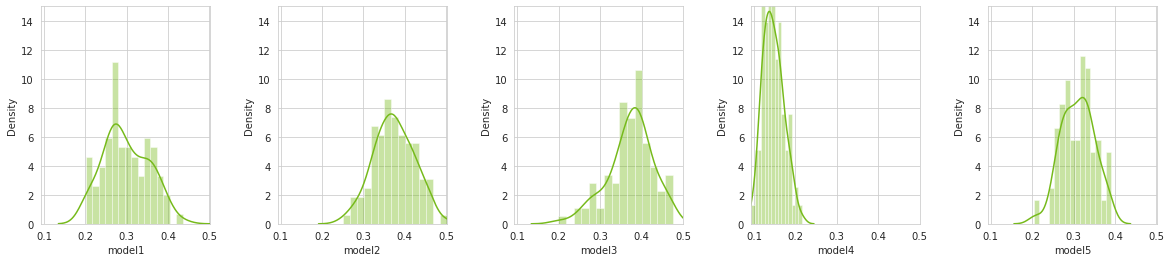

In [234]:
plot_dist(nt_results_1, colors[1], 15)

<AxesSubplot:>

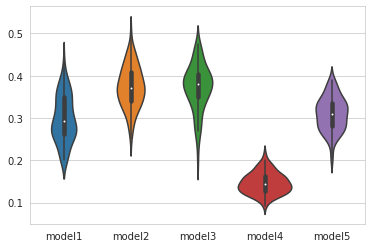

In [233]:
df_nt_results_1 = pd.DataFrame(nt_results_1)
sns.violinplot(data=df_nt_results_1[["model1", "model2", "model3", "model4", "model5"]])

#### 6.3.3 Unterscheidung zwischen richtigen und falsch Predicteten Modellen
##### 6.3.3.1 Richtig
###### 6.3.3.1.1 Entropie

In [ ]:
nt_results_c0 = load_wdCOM(df_m1_c0, "noise_tunnel")
nt_results_entropy_c0 = load_entropy(df_m1_c0, "noise_tunnel")

In [ ]:
plot_dist(nt_results_entropy_c0,"green",10)

In [ ]:
df_nt_results_entropy_c0 = pd.DataFrame(nt_results_entropy_c0)
sns.violinplot(data=df_nt_results_entropy_c0[["model1", "model2", "model3", "model4", "model5"]])

###### 6.3.1.1.2 D of COM

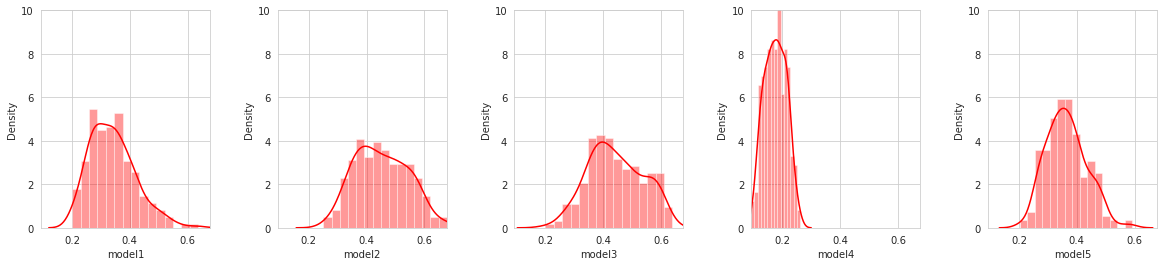

In [210]:
plot_dist(nt_results_c0, "green",10)

In [ ]:
df_nt_results_c0 = pd.DataFrame(nt_results_c0)
sns.violinplot(data=df_nt_results_c0[["model1", "model2", "model3", "model4", "model5"]])

##### 6.3.1.2 Falsch
###### 6.3.1.2.1 Entropie

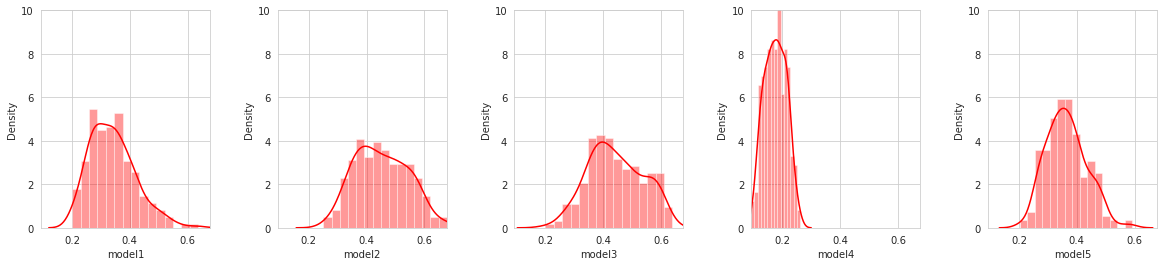

In [212]:
plot_dist(nt_results_c0, "red", 10)

###### 6.3.1.2.2 D of COM

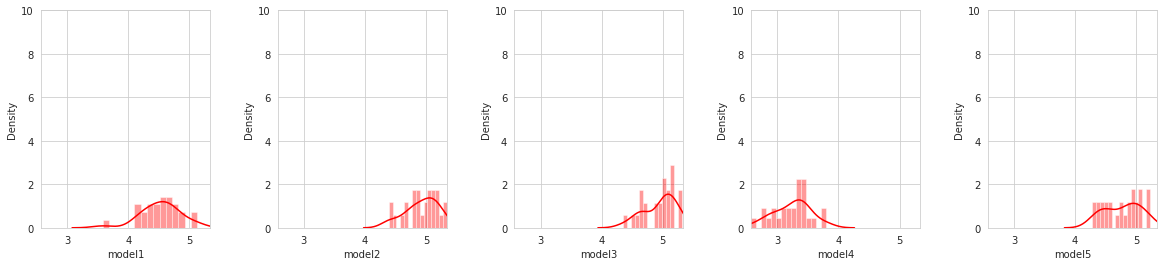

In [213]:
nt_results_entropy_c1 = load_entropy(df_m1_c1, "noise_tunnel")
plot_dist(nt_results_entropy_c1, "red", 10)

## 7.0 Vergleich von Okkulsion von verschiedenen Modellen

In [ ]:
fig = plt.figure(figsize=(20,4))
xai_methods = ["integraed_gradient","gradient_shap","occlusion","noise_tunnel"]
xai_dicts = [ig_results,gs_results,occ_results,nt_results]
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(3):
    ax = fig.add_subplot(1, 3, i)
    sns.histplot(xai_dicts[i][f"model1"],ax=ax,bins=15)
    #ax.set(ylim=(0, 60),xlim=(mn,mx))
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,4))
xai_methods = ["integraed_gradient","gradient_shap","occlusion","noise_tunnel"]
xai_dicts_entropy = [ig_results_entropy,gs_results_entropy,occ_results_entropy,nt_results_entropy]
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(3):
    ax = fig.add_subplot(1, 3, i)
    sns.histplot(xai_dicts_entropy[i][f"model1"],ax=ax,bins=15)
    #ax.set(ylim=(0, 60),xlim=(mn,mx))
plt.show()